
# Changes to be made

2. Different scales need to be used at different depths of the image. 
3. Normalization of image. - What is Normalization of Image? as we are using the features like, Color Histogram,    bin spatial and the HOG Features. 
4. Grayscale image - I don't think this is necessary as the whole image is converted into a different color space. 

In [132]:
import os
import numpy as np
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog

In [133]:
# # Loading the dataset
# Scars1 = glob.glob('vehicles_smallset/cars1/*.jpeg')
# Scars2 = glob.glob('vehicles_smallset/cars2/*.jpeg')
# Scars3 = glob.glob('vehicles_smallset/cars3/*.jpeg')

# Snotcars1 = glob.glob('non-vehicles_smallset/notcars1/*.jpeg')
# Snotcars2 = glob.glob('non-vehicles_smallset/notcars2/*.jpeg')
# Snotcars3 = glob.glob('non-vehicles_smallset/notcars3/*.jpeg')

# Scars = Scars1 + Scars2 + Scars3
# Snotcars = Snotcars1 + Snotcars2 + Snotcars3
# print (len(Scars))
# print (len(Snotcars))

In [134]:
# Loading the dataset
cars1 = glob.glob('dataset/vehicles/GTI_Far/*.png')
cars2 = glob.glob('dataset/vehicles/GTI_Left/*.png')
cars3 = glob.glob('dataset/vehicles/GTI_MiddleClose/*.png')
cars4 = glob.glob('dataset/vehicles/GTI_Right/*.png')
cars5 = glob.glob('dataset/vehicles/KITTI_extracted/*.png')

notcars1 = glob.glob('dataset/non-vehicles/Extras/*.png')
notcars2 = glob.glob('dataset/non-vehicles/GTI/*.png')

Scars = cars1 + cars2 + cars3 + cars4 + cars5 
Snotcars = notcars1 + notcars2

print(len(Scars))
print(len(Snotcars))

8792
8968


In [135]:
def bin_spatial(img, size=( 32, 32 )):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    numpy_array = np.hstack ((color1, color2, color3))
    return numpy_array
    
def color_hist(img, nbins=32, bins_range=( 0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features
    
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector = feature_vec)
        return features, hog_image
    
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector = feature_vec)
        return features
    
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8 , cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    features = []
    for file in imgs:
        file_features = []
        image = mpimg.imread(file)
        image = image.astype(np.float32)/255.0
        
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
                
        else: 
            feature_image = np.copy(image)      
        
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size = spatial_size)
            file_features.append(spatial_features)
            
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
            
        if hog_feat == True:
            
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append( get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)   
                
            else:
                hog_features = get_hog_features( feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                print (hog_features.shape)
            file_features.append(hog_features)
            
        features.append(np.concatenate(file_features))

    return features


In [136]:
# Obtaining the feature vector and the scaling of the input images. 
from sklearn.grid_search import GridSearchCV
from sklearn import svm

color_space = 'LUV'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (16 ,16)
hist_bins = 16

spatial_feat = False
hist_feat = False
hog_feat = True
y_start_stop = [None,None]

car_features = extract_features(Scars, color_space = color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(Snotcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack(( car_features, notcar_features)).astype(np.float64)   
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=23)

## Kernel, gamma value, C value. That minimizes prediction error. 
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters)

clf.fit( X_train , y_train )
score = clf.score( X_test, y_test )

print('The test score of the SVC is : ', score)


The test score of the SVC is :  0.992117117117


In [137]:
def add_heat (heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

In [143]:
from scipy.ndimage.measurements import label
import functools

history = []

def find_cars( my_img , ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, heat_threshold, no_of_frames):    
    
    global history
    
    on_windows = []
    test_img = np.copy(my_img)
    draw_img = np.copy(my_img)
    
    luv_image = cv2.cvtColor(my_img, cv2.COLOR_RGB2LUV)
    luv_image = luv_image.astype(np.float32)/255.0    
    
    for scale in scales: 
        print("The scale is: ", scale)
        
#   print (scale)
#   print ("ystart is: ",ystart," ystop : ",ystop)
        
        img_tosearch = luv_image[ystart:ystop, :, :]
        ctrans_tosearch = img_tosearch
        
#   print ("ctrans to search is: ")
#   plt.imshow(ctrans_tosearch)
#   plt.show()

        window = 64
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(img_tosearch.shape[1]//scale), np.int(img_tosearch.shape[0]//scale)))
        
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
        
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 

        nfeat_per_block = orient*cell_per_block**2
        cells_per_step = 2
        
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step
        
        hog1 = get_hog_features( ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features( ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features( ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
        for xb in range(nxsteps):
            for yb in range(nysteps):
                
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                
                hog_feat1 = hog1[ ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window ].ravel() 
                hog_feat2 = hog2[ ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window ].ravel() 
                hog_feat3 = hog3[ ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window ].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                
                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell
                
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)
                
                test_features = X_scaler.transform((hog_features).reshape(1, -1))
                test_prediction = svc.predict(test_features)
                
                if test_prediction == 1:
                    ## The below is scaling the obtined boxes to the original image size. 
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    on_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+win_draw+ystart)))
#                     cv2.rectangle(test_img, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart) , (0,0,255), 6)
    
#         plt.imshow(test_img)
#         plt.show()
    
    heat = np.zeros_like(draw_img[:,:,0]).astype(np.float)
#     print ("Shape of heat is: ",heat.shape)
    
    heat = add_heat(heat, on_windows)
#     print("The sum of the heat matrix is: ",np.sum(heat))
#     print("The heat image is: ")
#     plt.imshow(heat, cmap = 'Greys_r')
#     plt.show()
    
    if(len(history)>6):
        history = history[1:]
        history.append(heat)
    else:
        history.append(heat)
    
    if(len(history)<7):
        heat_history = functools.reduce(lambda a, b: a+b, history)/float(len(history))
    else:
        heat_history = functools.reduce(lambda a, b: a+b, history)/float(no_of_frames)
    
    heat = apply_threshold( heat_history, heat_threshold )
    heatmap = np.clip( heat, 0, 255 )
    labels = label( heatmap )
    
    draw_img = draw_labeled_bboxes( draw_img, labels )
    
    return draw_img


In [144]:
# Image conversion from PNG to JPG
# from PIL import Image

# im = Image.open('t1.png')
# rgb_im = im.convert('RGB')
# rgb_im.save('t1.jpg')

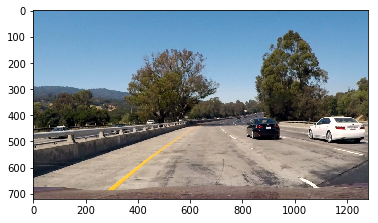

Came here
The scale is:  0.85
The scale is:  1
The scale is:  1.2
The scale is:  1.5
The scale is:  2
The scale is:  3
The scale is:  4
And here


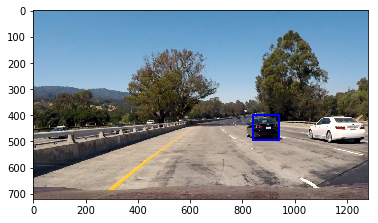

In [145]:
ystart = 400
ystop  = 656
scale  = [0.85, 1, 1.2, 1.5, 2, 3, 4]
heat_threshold = 2

image = mpimg.imread('project/test_images/test1.jpg')
# image = cv2.resize(image, (1280,720))

plt.imshow(image)
plt.show()
no_of_frames = 1.0
print("Came here")
out_img = find_cars(image, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, heat_threshold, no_of_frames)
print("And here")
plt.imshow(out_img)
plt.show()


In [146]:
# Testing on Videos
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [147]:
def process_image(image):
    ystart = 400
    ystop = 656
    
#   scale = [0.65, 0.85,1,1.2,1.5,2,3,4]
    scale = [0.85, 1, 1.2, 1.5, 2, 3, 4]
    
#   Heat threshold can also be changed to 3 or 4. Try both of them. 
    heat_threshold = 2
    
    no_of_frames = 7.0
    out_img = find_cars(image, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, heat_threshold, no_of_frames)
    return out_img


In [92]:
white_output = 'Soln1.mp4'
clip1 = VideoFileClip("project/project_video.mp4")
# clip1 = VideoFileClip("project/project_video.mp4").subclip(41, 43)

white_clip = clip1.fl_image(process_image) ## NOTE: this function expects color images

%time white_clip.write_videofile(white_output, audio=True)

[MoviePy] >>>> Building video Soln1.mp4
[MoviePy] Writing audio in Soln1TEMP_MPY_wvf_snd.mp3



100%|██████████| 1112/1112 [00:01<00:00, 707.40it/s]

[MoviePy] Done.
[MoviePy] Writing video Soln1.mp4



 12%|█▏        | 147/1261 [11:22<1:34:42,  5.10s/it]


 23%|██▎       | 294/1261 [21:49<53:36,  3.33s/it]


 35%|███▌      | 442/1261 [31:53<53:33,  3.92s/it]


 47%|████▋     | 593/1261 [42:12<52:59,  4.76s/it]


 59%|█████▉    | 744/1261 [52:39<34:25,  3.99s/it]


 71%|███████   | 894/1261 [1:02:13<20:50,  3.41s/it]


 82%|████████▏ | 1039/1261 [1:10:28<12:35,  3.40s/it]


 94%|█████████▎| 1182/1261 [1:18:35<04:29,  3.41s/it]


100%|█████████▉| 1260/1261 [1:23:14<00:04,  4.86s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Soln1.mp4 

CPU times: user 1h 18min 38s, sys: 2min 31s, total: 1h 21min 10s
Wall time: 1h 23min 18s


In [93]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))